In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridintersect import GridIntersect
#import pyemu

from shapely.geometry import Polygon, Point
import shapefile
from shapely.prepared import prep

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 14})

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

In [3]:
org_model_ws = os.path.join('..', 'temp_flopy_lumprem')
os.listdir(org_model_ws)

['ghb.ts',
 'ghb_blueviolet_segfile.dat',
 'ghb_limegreen_segfile.dat',
 'ghb_magenta_segfile.dat',
 'ghb_orange_segfile.dat',
 'ghb_red_segfile.dat',
 'ghb_royalblue_segfile.dat',
 'ghb_yellow_segfile.dat',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'hagfors_1_leakage.sfr.obs',
 'head.obs.csv',
 'lr_blueviolet.tpl',
 'lr_limegreen.tpl',
 'lr_lu1.tpl',
 'lr_magenta.tpl',
 'lr_orange.tpl',
 'lr_red.tpl',
 'lr_royalblue.tpl',
 'lr_yellow.tpl',
 'mfsim.lst',
 'mfsim.nam',
 'rch.ts',
 'sfr_leakage.obs.csv',
 'sfr_segfile.dat']

In [4]:
tmp_model_ws = os.path.join('..', 'temp_ml_param') # Safe to delete
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['ghb.ts',
 'ghb_blueviolet_segfile.dat',
 'ghb_limegreen_segfile.dat',
 'ghb_magenta_segfile.dat',
 'ghb_orange_segfile.dat',
 'ghb_red_segfile.dat',
 'ghb_royalblue_segfile.dat',
 'ghb_yellow_segfile.dat',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'hagfors_1_leakage.sfr.obs',
 'head.obs.csv',
 'lr_blueviolet.tpl',
 'lr_limegreen.tpl',
 'lr_lu1.tpl',
 'lr_magenta.tpl',
 'lr_orange.tpl',
 'lr_red.tpl',
 'lr_royalblue.tpl',
 'lr_yellow.tpl',
 'mfsim.lst',
 'mfsim.nam',
 'rch.ts',
 'sfr_leakage.obs.csv',
 'sfr_segfile.dat']

In [5]:
ml_name = 'hagfors_1'

In [6]:
sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package obs...
    loading package sfr...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package ghb...
  loading ims package hagfors_1...


Set all data external so that PEST can adjust parameter values during history matching:

In [7]:
sim.set_all_data_external(True)

In [8]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package rch_ts...
    writing package rch...
    writing package gwf_obs...
    writing package sfr_obs...
    writing package sfr...
    writing package sto...
    writing package oc...
    writing package npf...
    writing package ic...
    writing package ghb_ts...
    writing package ghb...


In [9]:
gwf = sim.get_model(ml_name)

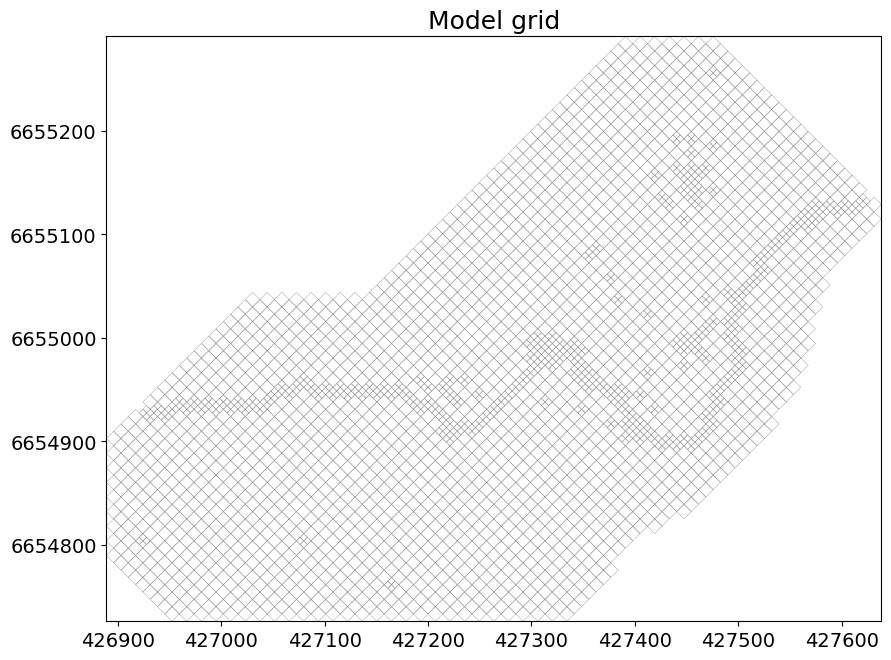

In [10]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Model grid', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

plt.show()

## Generate pilot points
3D-pilot points will be generated for the following areal properties:
- SY & SS (perhaps SS could be skipped?)
- Porosity and possibly diffusion/dispersion and any other parameter needed to represent transport
- Kh and Kz

In addition, pilot points will be generated along the following linear features:
- Streambed hydraulic conductivity along Creek Örbäcken (SFR package)
- GHB conductance

### 3D pilot points
Because we want to do a data-worth analysis, we should consider the total amount of pilot points to be employed to find a suitable compromise between adjustable parameters and model run-time.

For this reason, we will create different sets of pilot points for each parameter type (in order to not use an exessive amount of pps).

Sy, SS and possibly porosity (along with other parameters that govern transport) could be parameterized using a coarser pp-spacing, so let's start with that.

However, before we start, let's import the observation locations, so that we can see how the pilot points will be located in relation to them:

In [11]:
sfr_obs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))
head_obs = pd.read_excel(os.path.join(observations_pth, 'obs_head_per_layer.xlsx')).drop_duplicates(subset=['POINT_X', 'POINT_Y'])
head_obs['TYPE'] = 'HEAD'

In [12]:
obs_points = pd.concat([head_obs, sfr_obs])
display(obs_points)

,NAME,POINT_X,POINT_Y,LAYER,TYPE
0,B9-2,426918.374000,6.654803e+06,1.0,HEAD
1,B10-2,427074.709423,6.654805e+06,1.0,HEAD
2,B12-1,427448.188505,6.655156e+06,1.0,HEAD
3,B16-1,427409.547301,6.655023e+06,1.0,HEAD
4,B2-1,427384.172044,6.655037e+06,1.0,HEAD
...,...,...,...,...,...
2,NI15-O46-STG,427316.293421,6.655000e+06,NaN,STAGE
3,NI15-O47-STG,427294.946661,6.654962e+06,NaN,STAGE
4,NI15-O48-STG,427166.670722,6.654947e+06,NaN,STAGE
5,GAGE-1,427070.614000,6.654949e+06,NaN,INFLOW


#### Coarse 3D pilot points
Let's create the coarse pilot point distribution:

In [13]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'model_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array

Instantiate a shapely polygon of the model boundary:

In [14]:
mlb_shapely = Polygon(mlb_shape)

Create prepared polygon of the model boundary:

In [15]:
#mlb_shapely_prep = prep(mlb_shapely.buffer(50)) buffer cause an issue because the grid can't be sampled outside the model boundary
mlb_shapely_prep = prep(mlb_shapely)

Construct a rectangular mesh of points:

In [16]:
xmin, xmax, ymin, ymax = 426900, 427700, 6654650, 6655350 # These are the same coordinates used to construct the base-grid
resolution = 30 # Equal space (in meters) between pilot points
basepoints = []
for lat in np.arange(xmin, xmax, resolution):
    for lon in np.arange(ymin, ymax, resolution):
        basepoints.append(Point((round(lat,4), round(lon,4))))

Use the shapely `contains` (point-in-polygon method) to select points inside the model boundary (increase the number of pps once workflow is confirmed working):

In [17]:
basepip = [] # Basepoints in polygon
for point in basepoints:
    if mlb_shapely_prep.contains(point):
        basepip.append(point)
print(f'Number of points per layer: {len(basepip)}') # We need to extend it into three dimensions

Number of points per layer: 267


Plot the position of the pilot points on top of the model grid:

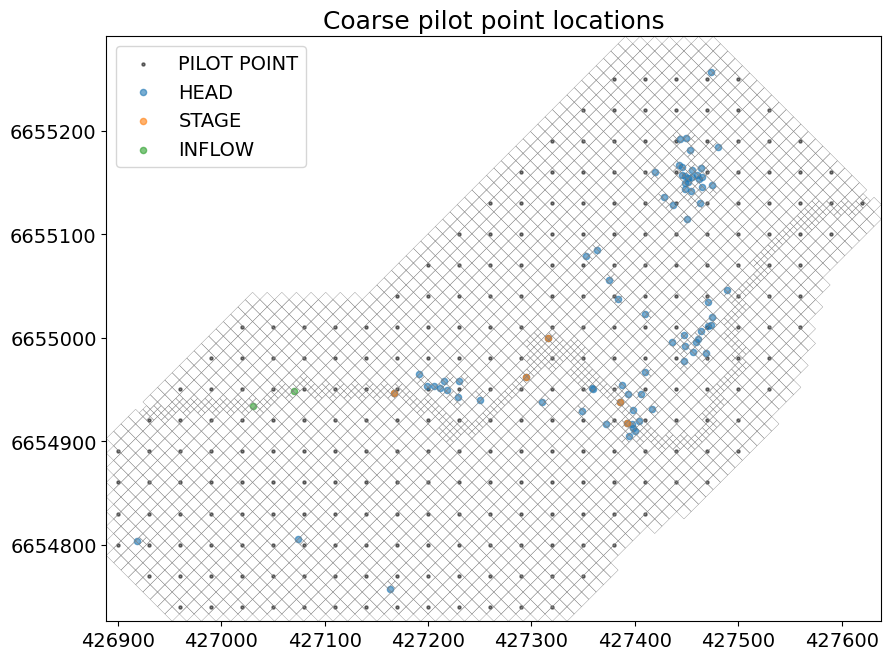

In [18]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Coarse pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = np.array([i.coords[0] for i in basepip])[:,0]
y = np.array([i.coords[0] for i in basepip])[:,1]
plt.scatter(x, y, s=5, c='black', alpha=0.5, label='PILOT POINT')

for category in obs_points['TYPE'].unique():
    x = obs_points.loc[obs_points['TYPE'] == category]['POINT_X']
    y = obs_points.loc[obs_points['TYPE'] == category]['POINT_Y']
    ax.scatter(x, y, s=20, alpha=0.6, label=category)
    
plt.legend()
plt.show()

These points now need to be assigned a z-value, since we are going to use 3D-pilot points. To do this, we will need to intersect the model grid and retrieve the z-values of each layer, so that a copy of these pps can be positioned in each of the three layers:

In [19]:
ix = GridIntersect(gwf.modelgrid)

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\flopy\utils\gridintersect.py:317: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [20]:
pp_intersect = {
    'cellids': [],
    'vertices': [],
    'ixshapes': [],
}
for point in basepip:
    pp_intersect['cellids'].append(ix.intersect(point).cellids[0])
    pp_intersect['vertices'].append(ix.intersect(point).vertices[0])
    pp_intersect['ixshapes'].append(ix.intersect(point).ixshapes[0])

In [21]:
pp_intersect = pd.DataFrame(pp_intersect)
display(pp_intersect)

,cellids,vertices,ixshapes
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800)
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830)
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860)
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890)
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770)
...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190)
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100)
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130)
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160)


We can see that the order is respected:

In [22]:
[i.coords[0] for i in basepip][:5]

[(426900.0, 6654800.0),
 (426900.0, 6654830.0),
 (426900.0, 6654860.0),
 (426900.0, 6654890.0),
 (426930.0, 6654770.0)]

Let's use the cellids to sample pilot point elevations (**this takes about 2 minutes on my laptop for 295 cells** and could/should probably be speed up somehow - considering it has to be done for top, botm1, botm2 and botm3):

In [23]:
def get_grid_elevation(elevation_array, index_array):
    '''
    returns list of elevations
    '''
    
    elevations = list(elevation_array)
    indices = list(index_array)
    
    return [elevation_array[i] for i in index_array]

In [24]:
pp_intersect['top'] = get_grid_elevation(elevation_array = gwf.modelgrid.top, index_array=pp_intersect['cellids'])

In [25]:
pp_intersect['botm_1'] = get_grid_elevation(gwf.modelgrid.botm[0], pp_intersect['cellids'])
pp_intersect['botm_2'] = get_grid_elevation(gwf.modelgrid.botm[1], pp_intersect['cellids'])
pp_intersect['botm_3'] = get_grid_elevation(gwf.modelgrid.botm[2], pp_intersect['cellids'])

In [26]:
pp_intersect

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830),136.330093,124.304199,119.473198,117.513603
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860),136.800598,125.293098,120.813400,118.661400
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890),137.616699,126.236198,121.958702,119.823601
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770),135.541397,123.152000,118.293098,115.931099
...,...,...,...,...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190),155.324707,140.380096,137.393005,135.419205
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100),146.750107,139.275497,136.379303,134.998505
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130),143.478104,139.465393,136.847900,135.460999
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160),152.567307,139.972504,137.633301,135.983704


Create pps in-between the layer boundaries (i.e. vertically centered in the cells):

In [27]:
pp_intersect['pps_l1'] = (pp_intersect['top'] + pp_intersect['botm_1']) / 2

In [28]:
pp_intersect['pps_l2'] = (pp_intersect['botm_1'] + pp_intersect['botm_2']) / 2

In [29]:
pp_intersect['pps_l3'] = (pp_intersect['botm_2'] + pp_intersect['botm_3']) / 2

In [30]:
display(pp_intersect)

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3,pps_l1,pps_l2,pps_l3
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601,129.505047,120.970249,117.295250
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830),136.330093,124.304199,119.473198,117.513603,130.317146,121.888699,118.493401
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860),136.800598,125.293098,120.813400,118.661400,131.046848,123.053249,119.737400
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890),137.616699,126.236198,121.958702,119.823601,131.926449,124.097450,120.891151
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770),135.541397,123.152000,118.293098,115.931099,129.346699,120.722549,117.112099
...,...,...,...,...,...,...,...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190),155.324707,140.380096,137.393005,135.419205,147.852402,138.886551,136.406105
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100),146.750107,139.275497,136.379303,134.998505,143.012802,137.827400,135.688904
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130),143.478104,139.465393,136.847900,135.460999,141.471748,138.156647,136.154449
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160),152.567307,139.972504,137.633301,135.983704,146.269905,138.802902,136.808502


Add x, y and clean up df:

In [31]:
pp_intersect['x'] = np.array([i.coords[0] for i in basepip])[:,0]
pp_intersect['y'] = np.array([i.coords[0] for i in basepip])[:,1]

In [32]:
pp_intersect = pp_intersect[['x', 'y', 'pps_l1', 'pps_l2', 'pps_l3']]

In [33]:
pp_intersect

,x,y,pps_l1,pps_l2,pps_l3
0,426900.0,6654800.0,129.505047,120.970249,117.295250
1,426900.0,6654830.0,130.317146,121.888699,118.493401
2,426900.0,6654860.0,131.046848,123.053249,119.737400
3,426900.0,6654890.0,131.926449,124.097450,120.891151
4,426930.0,6654770.0,129.346699,120.722549,117.112099
...,...,...,...,...,...
262,427560.0,6655190.0,147.852402,138.886551,136.406105
263,427590.0,6655100.0,143.012802,137.827400,135.688904
264,427590.0,6655130.0,141.471748,138.156647,136.154449
265,427590.0,6655160.0,146.269905,138.802902,136.808502


Visualize

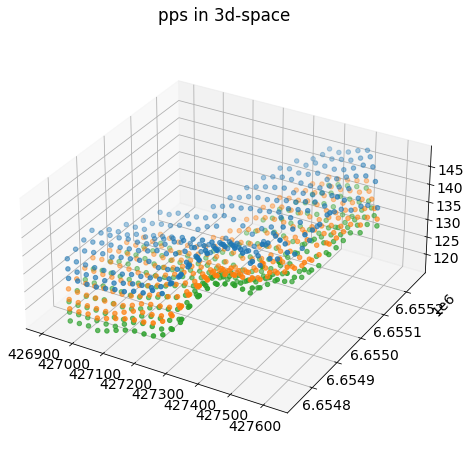

In [34]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_intersect.x.values, pp_intersect.y.values

ax.scatter(x, y, pp_intersect.pps_l1.values)
ax.scatter(x, y, pp_intersect.pps_l2.values)
ax.scatter(x, y, pp_intersect.pps_l3.values)
plt.title('pps in 3d-space')
pyplot.show()

Convert the dataframe into a 3d pilot point file format:

In [35]:
pp_coarse3d = pd.melt(pp_intersect, id_vars=['x', 'y'], value_vars=['pps_l1', 'pps_l2', 'pps_l3'])

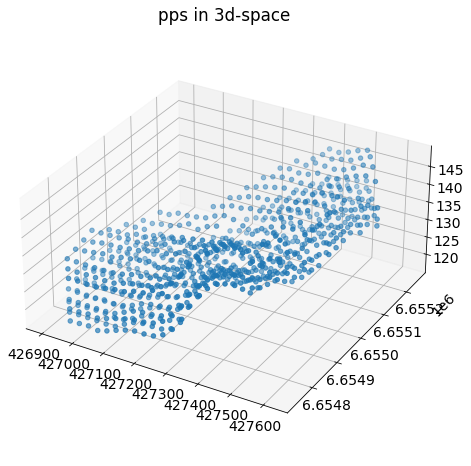

In [36]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_coarse3d.x.values, pp_coarse3d.y.values

ax.scatter(x, y, pp_coarse3d.value.values)
plt.title('pps in 3d-space')
pyplot.show()

Insert columns:

In [37]:
pp_coarse3d['name'] = [f'ppc{i:04d}' for i in pp_coarse3d.index.values] # ppc = pilot point coarse.

In [38]:
pp_coarse3d[['zone','val']] = 1, 1
pp_coarse3d['z'] = pp_coarse3d['value']

In [39]:
pp_coarse3d['layer'] = [int(i[-1]) for i in pp_coarse3d['variable']]

In [40]:
pp_coarse3d = pp_coarse3d[['name', 'x', 'y', 'z', 'zone', 'val', 'layer']]

In [41]:
display(pp_coarse3d)

,name,x,y,z,zone,val,layer
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1
...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3


In [42]:
from lumpyrem import run
#MKPPSTAT
# mkppstat requires no headers in ppoint file ...sigh...
pp_coarse3d.to_csv(os.path.join(tmp_model_ws, 'mkppoints3d_coarse.dat'),
                       header=None, index=False, sep='\t')

In [43]:
# Input for MKPPSTAT
# A (a)-factor of 1.5 is often reasonable. from tutorial 
npoints_h, npoints_v = 10, 10 # np-horizontal, np-vertical
a_h, a_v = 1.2, 1.2 # a-horizontal, a-vertical
# run MKPPSTAT
run.run_process(
    'mkppstat3d',
    path=tmp_model_ws,
    commands=['mkppoints3d_coarse.dat', npoints_h, a_h, npoints_v, a_v, 'ppstat3d_coarse.dat']
)

 
 Program MKPPSTAT3D writes a pilot points statistical specification file 
   based on a 3D pilot points file using local pilot point density to set 
   local variogram range.
 
 Enter name of 3D pilot points file:   - data for 801 pilot points read from pilot points file 
    mkppoints3d_coarse.dat
 
 Enter no. of pilot points to compute local ave. hor. pp. sepn.:  Enter factor of ave. hor. sepn. for local variogram hor. "a" value: 
 Enter no. of pilot points to compute local ave. vert. pp. sepn.:  Enter factor of ave. vert. sepn. for local variogram vert. "a" value: 
 Enter name for 3D pilot point statistical spec. file:  - file ppstat3d_coarse.dat written ok
 



In [44]:
# run PPCOV3D_SVA - pilot point covariance 3d - spatially varying anisotropy
run.run_process(
    'ppcov3d_sva',
    path=tmp_model_ws,
    commands=['ppstat3d_coarse.dat', 'y', 1, 'x',  'cov3d_coarse.mat', '']
)

 
 Program PPCOV3D_SVA creates a covariance matrix file for 3D pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of 3D pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 801 pilot points read from file ppstat3d_coarse.dat
 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]:  Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter names (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov3d_coarse.mat written ok.



In [45]:
# Load cov mat file with Pyemu for further processing
import pyemu
covmat_coarse = pyemu.Cov.from_ascii(os.path.join(tmp_model_ws, "cov3d_coarse.mat"))

# This covaraince matrix can now be used as the base for all pilot point parameters. 
# Note that in this case the variance is 1, so it is easy to scale to a parameters prior varaince
# Depending on how you setup the scrpt, variance can be assigned at various stages (i.e. when running PPCOV_SVA, or by manipulating the matrix later)
# Note that parameter names (headers and row names) come from the parameter name sin the ppoint file. These can have a prefix added by PPCOV_SVA, or changed in the dataframe. The latter is more versatile.
covmat_coarse.to_dataframe().head()

,ppc0000,ppc0001,ppc0002,ppc0003,ppc0004,ppc0005,ppc0006,ppc0007,ppc0008,ppc0009,...,ppc0791,ppc0792,ppc0793,ppc0794,ppc0795,ppc0796,ppc0797,ppc0798,ppc0799,ppc0800
ppc0000,1.000000,0.351344,0.123454,0.058025,0.263136,0.352832,0.227973,0.095991,0.036231,0.020228,...,2.540665e-11,1.738932e-11,1.149566e-11,7.339267e-12,4.548162e-12,3.287491e-11,5.076260e-11,2.840003e-12,2.242443e-11,1.483235e-11
ppc0001,0.351344,1.000000,0.351516,0.123462,0.097101,0.227802,0.352695,0.227784,0.095927,0.037066,...,3.566945e-11,2.541688e-11,1.744527e-11,1.154117e-11,7.389148e-12,4.559285e-12,6.659558e-12,4.404591e-12,2.894020e-12,1.711758e-12
ppc0002,0.123454,0.351516,1.000000,0.350911,0.036860,0.096147,0.228960,0.352758,0.227576,0.097370,...,4.803257e-11,3.568478e-11,2.547662e-11,1.749678e-11,1.159853e-11,7.396192e-12,9.567879e-12,6.590298e-12,4.466308e-12,2.515587e-12
ppc0003,0.058025,0.123462,0.350911,1.000000,0.020102,0.036329,0.096866,0.228308,0.352865,0.260746,...,6.198417e-11,4.808761e-11,3.577176e-11,2.554956e-11,1.756909e-11,1.230042e-10,1.377882e-10,9.507911e-12,7.385226e-11,4.230494e-11
ppc0004,0.263136,0.097101,0.036860,0.020102,1.000000,0.352851,0.123893,0.043382,0.015176,0.008840,...,4.557994e-11,2.954994e-11,1.852925e-11,1.123638e-11,6.623331e-12,4.420615e-11,7.991833e-11,4.460068e-12,3.229014e-11,2.276009e-11


Is this matrix only used during regularization?

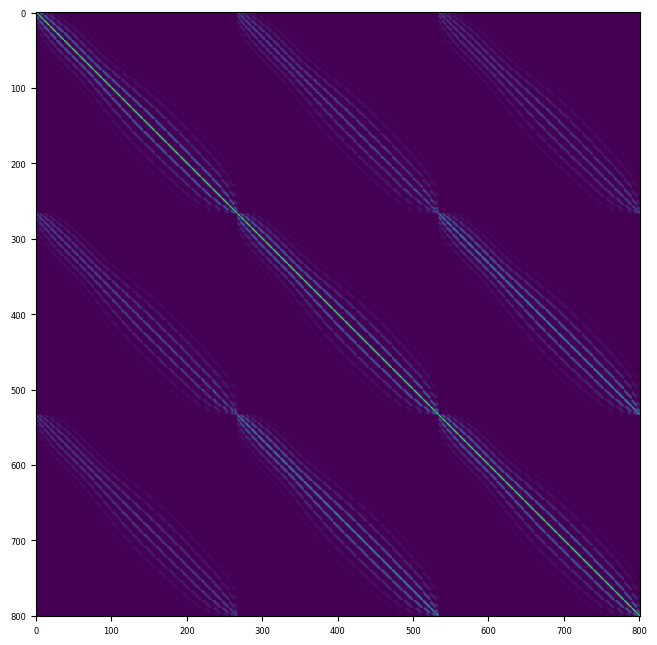

In [46]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(covmat_coarse.as_2d)

In [47]:
pp_coarse3d[['kh', 'kv', 'sy', 'ss']] = 86.4, 8.64, 0.2, 0.00001

In [48]:
pp_coarse3d

,name,x,y,z,zone,val,layer,kh,kv,sy,ss
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1,86.4,8.64,0.2,0.00001
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1,86.4,8.64,0.2,0.00001
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1,86.4,8.64,0.2,0.00001
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1,86.4,8.64,0.2,0.00001
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1,86.4,8.64,0.2,0.00001
...,...,...,...,...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3,86.4,8.64,0.2,0.00001
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3,86.4,8.64,0.2,0.00001
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3,86.4,8.64,0.2,0.00001
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3,86.4,8.64,0.2,0.00001


In [49]:
pp_coarse3d.to_csv(os.path.join(tmp_model_ws, 'pp3d_coarse.dat'),
                       header=None, index=False, sep='\t')

## Setup parameterization for 3D elements (K, storage, porosity)

In [50]:
def write_plproc_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

Calculate kriging factors (porosity not included yet):

In [51]:
write_plproc_script(os.path.join(tmp_model_ws, 'plproc1_temp.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file={ml_name}.disv.grb,               &
                            dimensions=2,                             &
                            slist_layer_idomain=idomain1;  layer=1,   &
                            slist_layer_idomain=idomain2;  layer=2,   &
                            slist_layer_idomain=idomain3;  layer=3)



### Read 3D pilot-points file ###
cl_pp = read_list_file(file=pp3d_coarse.dat,               &
                       id_type=character,                  &
                       dimensions=2,                       &
                       slist=zone; col=5,                  &
                       slist=lyr; col=7,                   &
                       plist=kh_pp; col=8,                 &
                       plist=kv_pp; col=9,                 &
                       plist=sy_pp; col=10,                &
                       plist=ss_pp; col=11)


### Calculate kriging factors for each layer ###
calc_kriging_factors_auto_2d(                    &
           target_clist=cl_mf,                   &
           source_clist=cl_pp;select=(lyr==1),   &
           file=factors_pp_lyr1.dat)

calc_kriging_factors_auto_2d(                    &
           target_clist=cl_mf,                   &
           source_clist=cl_pp;select=(lyr==2),   &
           file=factors_pp_lyr2.dat)

calc_kriging_factors_auto_2d(                    &
           target_clist=cl_mf,                   &
           source_clist=cl_pp;select=(lyr==3),   &
           file=factors_pp_lyr3.dat)

'''
])

In [52]:
# run PLPROC
run.run_process(
    'plproc',
    path=tmp_model_ws,
    commands=['plproc1_temp.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc1_temp.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=hagfors_1.disv.grb,dimensions=2,slist_...
> cl_pp=read_list_file(file=pp3d_coarse.dat,id_type=character,dimension...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
 
End of file: no more commands to process.



## Setup parameterization for linear elements (GHBs & SFR)
Setup pilot points for linear boundary conditions General Head Boundaries (GHBs) and Creek Örbäcken (SFR), starting with SFR:

In [53]:
segfile = pd.read_csv(os.path.join(tmp_model_ws, 'sfr_segfile.dat'), sep='\t', names=['x', 'y', 'seg'])
display(segfile)

,x,y,seg
0,426924.228,6654927.297,r1s1
1,426927.764,6654930.833,r2s1
2,426931.299,6654927.297,r3s1
3,426934.835,6654930.833,r4s1
4,426938.370,6654927.297,r5s1
...,...,...,...
260,427610.122,6655125.287,r261s1
261,427613.657,6655128.823,r262s1
262,427617.193,6655132.358,r263s1
263,427620.729,6655128.823,r264s1


Fix the segments. This should probably be done in a better way and perhaps changed after the first round of history matching to get a better representation of stream reaches. This solution is just to make things work.

In [54]:
def largest_divisor(n):
    a = 1
    for i in range(2, n):
        if n % i == 0:
            a = i
    return a

In [55]:
nseg = largest_divisor(len(segfile))
#nseg = largest_divisor(nseg) # divide again to reduce the amount of pps from 135 to 45 (perhaps a stupid move)
print(nseg)

53


In [56]:
rows_per_seg = int(len(segfile) / nseg)
print(rows_per_seg)

5


In [57]:
for i in range(nseg):
    segfile.loc[(i * rows_per_seg):((i + 1) * rows_per_seg), ('seg')] = f's{i + 1}'

In [58]:
segfile

,x,y,seg
0,426924.228,6654927.297,s1
1,426927.764,6654930.833,s1
2,426931.299,6654927.297,s1
3,426934.835,6654930.833,s1
4,426938.370,6654927.297,s1
...,...,...,...
260,427610.122,6655125.287,s53
261,427613.657,6655128.823,s53
262,427617.193,6655132.358,s53
263,427620.729,6655128.823,s53


Rewrite seglist:

In [59]:
segfile.to_csv(
    os.path.join(tmp_model_ws, 'sfr_segfile.dat'),
    header=None,
    index=False,
    sep='\t',
    float_format='%.3f'
)

### GHB Seglists

In [60]:
ghb_seglists = []
for filename in os.listdir(tmp_model_ws):
    if 'ghb_' in filename and '_segfile.dat' in filename:
        ghb_seglists.append(filename)

In [61]:
ghb_seglists_dfs = {}

In [62]:
for filename in ghb_seglists:
    ghb_seglists_dfs[filename.replace('_segfile.dat', '')] = pd.read_csv(
        os.path.join(tmp_model_ws, filename),
        sep='\t',
        names=['x', 'y', 'seg']
    )

In [63]:
ghb_seglists_dfs['ghb_red']

,x,y,seg
0,427387.0,6655280.0,tempval
1,427399.0,6655280.0,tempval
2,427412.0,6655280.0,tempval
3,427426.0,6655280.0,tempval
4,427438.0,6655280.0,tempval
5,427452.0,6655280.0,tempval
6,427466.0,6655280.0,tempval
7,427479.0,6655280.0,tempval
8,427487.0,6655272.0,tempval
9,427497.0,6655263.0,tempval


Assign segment IDs:

In [64]:
for k,v in ghb_seglists_dfs.items():
    print(f'rows in {k}: {len(v["seg"])}')

rows in ghb_blueviolet: 22
rows in ghb_limegreen: 8
rows in ghb_magenta: 18
rows in ghb_orange: 6
rows in ghb_red: 20
rows in ghb_royalblue: 30
rows in ghb_yellow: 33


In [65]:
for k,segfile in ghb_seglists_dfs.items():
    nseg = largest_divisor(len(segfile))
    rows_per_seg = int(len(segfile) / nseg)
    for i in range(nseg):
        segfile.loc[(i * rows_per_seg):((i + 1) * rows_per_seg), ('seg')] = f's{i + 1}'

In [66]:
ghb_seglists_dfs['ghb_red']

,x,y,seg
0,427387.0,6655280.0,s1
1,427399.0,6655280.0,s1
2,427412.0,6655280.0,s2
3,427426.0,6655280.0,s2
4,427438.0,6655280.0,s3
5,427452.0,6655280.0,s3
6,427466.0,6655280.0,s4
7,427479.0,6655280.0,s4
8,427487.0,6655272.0,s5
9,427497.0,6655263.0,s5


I'm still not sure about the implification of segments... for example there are three rows in ghb_orange and ghb_red each. However, ghb_red is about 5 times the size of ghb_orange... Assigning a single segment to all ghbs except yellow:

In [67]:
ghb_seglists_dfs

{'ghb_blueviolet':            x          y  seg
 0   426899.0  6654905.0   s1
 1   426912.0  6654919.0   s1
 2   426926.0  6654932.0   s2
 3   426937.0  6654943.0   s2
 4   426950.0  6654957.0   s3
 5   426964.0  6654971.0   s3
 6   426974.0  6654981.0   s4
 7   426986.0  6654993.0   s4
 8   427000.0  6655007.0   s5
 9   427013.0  6655020.0   s5
 10  427025.0  6655032.0   s6
 11  427040.0  6655032.0   s6
 12  427056.0  6655032.0   s7
 13  427074.0  6655032.0   s7
 14  427090.0  6655032.0   s8
 15  427107.0  6655032.0   s8
 16  427123.0  6655032.0   s9
 17  427139.0  6655032.0   s9
 18  427148.0  6655041.0  s10
 19  427159.0  6655051.0  s10
 20  427170.0  6655063.0  s11
 21  427183.0  6655076.0  s11,
 'ghb_limegreen':           x          y seg
 0  427374.0  6654776.0  s1
 1  427360.0  6654762.0  s1
 2  427348.0  6654750.0  s2
 3  427335.0  6654737.0  s2
 4  427319.0  6654737.0  s3
 5  427302.0  6654737.0  s3
 6  427289.0  6654737.0  s4
 7  427273.0  6654737.0  s4,
 'ghb_magenta':      

In [68]:
for k, segfile in ghb_seglists_dfs.items():
    segfile.to_csv(
        os.path.join(tmp_model_ws, f'{k}_segfile.dat'),
        header=None,
        index=False,
        sep='\t',
        float_format='%.3f'
    )

In [69]:
write_plproc_script(os.path.join(tmp_model_ws, 'plproc_seglist_temp1.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(                &
    file={ml_name}.disv.grb,                &
    dimensions=2,                           &
    slist_layer_idomain=idomain1;  layer=1, &
    slist_layer_idomain=idomain2;  layer=2, &
    slist_layer_idomain=idomain3;  layer=3  &
    )


### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)
    
### Read GHB seglist files ###
sl_ghb_red = read_segfile(file="ghb_red_segfile.dat", protocol=table)
sl_ghb_orange = read_segfile(file="ghb_orange_segfile.dat", protocol=table)
sl_ghb_yellow = read_segfile(file="ghb_yellow_segfile.dat", protocol=table)
sl_ghb_limegreen = read_segfile(file="ghb_limegreen_segfile.dat", protocol=table)
sl_ghb_royalblue = read_segfile(file="ghb_royalblue_segfile.dat", protocol=table)
sl_ghb_blueviolet = read_segfile(file="ghb_blueviolet_segfile.dat", protocol=table)
sl_ghb_magenta = read_segfile(file="ghb_magenta_segfile.dat", protocol=table)


### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=5.0)

### Create clist with sl_ghb* as its base ###
cl_ghb_red_pp = create_clist_from_seglist(seglist=sl_ghb_red, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_orange_pp = create_clist_from_seglist(seglist=sl_ghb_orange, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_yellow_pp = create_clist_from_seglist(seglist=sl_ghb_yellow, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_limegreen_pp = create_clist_from_seglist(seglist=sl_ghb_limegreen, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_royalblue_pp = create_clist_from_seglist(seglist=sl_ghb_royalblue, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_blueviolet_pp = create_clist_from_seglist(seglist=sl_ghb_blueviolet, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_magenta_pp = create_clist_from_seglist(seglist=sl_ghb_magenta, linkage_type=endpoints, dist_thresh=5.0)


### Write reports (pps will be constructed based on theses reports) ###
cl_sfr_pp.report_dependent_lists(file='report_sfr_seglist.dat')

cl_ghb_red_pp.report_dependent_lists(file='report_ghb_red_seglist.dat')
cl_ghb_orange_pp.report_dependent_lists(file='report_ghb_orange_seglist.dat')
cl_ghb_yellow_pp.report_dependent_lists(file='report_ghb_yellow_seglist.dat')
cl_ghb_limegreen_pp.report_dependent_lists(file='report_ghb_limegreen_seglist.dat')
cl_ghb_royalblue_pp.report_dependent_lists(file='report_ghb_royalblue_seglist.dat')
cl_ghb_blueviolet_pp.report_dependent_lists(file='report_ghb_blueviolet_seglist.dat')
cl_ghb_magenta_pp.report_dependent_lists(file='report_ghb_magenta_seglist.dat')
'''
])

RUN PLPROC:

In [70]:
# run PLPROC
run.run_process(
    'plproc',
    path=tmp_model_ws,
    commands=['plproc_seglist_temp1.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_seglist_temp1.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=hagfors_1.disv.grb,dimensions=2,slist_...
> sl_sfr=read_segfile(file="sfr_segfile.dat",protocol=table)
> sl_ghb_red=read_segfile(file="ghb_red_segfile.dat",protocol=table)
> sl_ghb_orange=read_segfile(file="ghb_orange_segfile.dat",protocol=table)
> sl_ghb_yellow=read_segfile(file="ghb_yellow_segfile.dat",protocol=table)
> sl_ghb_limegreen=read_segfile(file="ghb_limegreen_segfile.dat",protoc...
> sl_ghb_royalblue=read_segfile(file="ghb_royalblue_segfile.dat",protoc...
> sl_ghb_blueviolet=read_segfile(file="ghb_blueviolet_segfile.dat",prot...
> sl_ghb_magenta=read_segfile(file="ghb_magenta_segfile.dat",protocol=t...
> cl_sfr_pp=create_clist_from_seglist(seglist=sl_sfr,linkage_type=endpo...
> cl_ghb_red_pp=create_clist_from_seglist(seglist=sl_

### Create SEGLIST pilot points from the report files

Define a function for writing conductance files:

In [71]:
def write_conductance(filename, conductance):
    df = pd.read_csv(os.path.join(tmp_model_ws, filename), skiprows=[0, 1, 2])
    
    df['ID'] = df.index + 1
    df['conductance'] = conductance
    df = df[['ID', 'conductance']]
    new_filename = filename.replace('report_', '').replace('_seglist.dat', '')
    new_filename = new_filename + '_cond.dat'
    
    print(f'Writing {new_filename}')
    df.to_csv(
        os.path.join(tmp_model_ws, new_filename),
        header=None,
        index=False,
        sep='\t',
    )

In [72]:
reportfiles = [i for i in os.listdir(tmp_model_ws) if 'report_' in i]
display(reportfiles)

['report_ghb_blueviolet_seglist.dat',
 'report_ghb_limegreen_seglist.dat',
 'report_ghb_magenta_seglist.dat',
 'report_ghb_orange_seglist.dat',
 'report_ghb_red_seglist.dat',
 'report_ghb_royalblue_seglist.dat',
 'report_ghb_yellow_seglist.dat',
 'report_sfr_seglist.dat']

In [73]:
for file in reportfiles:
    write_conductance(file, 86.4) # Assigning 86.4 as starting K

Writing ghb_blueviolet_cond.dat
Writing ghb_limegreen_cond.dat
Writing ghb_magenta_cond.dat
Writing ghb_orange_cond.dat
Writing ghb_red_cond.dat
Writing ghb_royalblue_cond.dat
Writing ghb_yellow_cond.dat
Writing sfr_cond.dat


### Calculate kriging interpolation factors for the SEGLISTs

In [74]:
write_plproc_script(os.path.join(tmp_model_ws, 'plproc_seglist_temp2.dat'), [
f'''
### Read model grid ###

cl_mf = read_mf6_grid_specs(  &
    file={ml_name}.disv.grb,  &
    dimensions=3,             & # Note 3D in this case
    slist_layernum = layer,   &
    slist_idomain = idomain   &
    )


### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)
    
### Read GHB seglist files ###
sl_ghb_red = read_segfile(file="ghb_red_segfile.dat", protocol=table)
sl_ghb_orange = read_segfile(file="ghb_orange_segfile.dat", protocol=table)
sl_ghb_yellow = read_segfile(file="ghb_yellow_segfile.dat", protocol=table)
sl_ghb_limegreen = read_segfile(file="ghb_limegreen_segfile.dat", protocol=table)
sl_ghb_royalblue = read_segfile(file="ghb_royalblue_segfile.dat", protocol=table)
sl_ghb_blueviolet = read_segfile(file="ghb_blueviolet_segfile.dat", protocol=table)
sl_ghb_magenta = read_segfile(file="ghb_magenta_segfile.dat", protocol=table)


### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=5.0)

### Create clist with sl_ghb* as its base ###
cl_ghb_red_pp = create_clist_from_seglist(seglist=sl_ghb_red, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_orange_pp = create_clist_from_seglist(seglist=sl_ghb_orange, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_yellow_pp = create_clist_from_seglist(seglist=sl_ghb_yellow, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_limegreen_pp = create_clist_from_seglist(seglist=sl_ghb_limegreen, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_royalblue_pp = create_clist_from_seglist(seglist=sl_ghb_royalblue, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_blueviolet_pp = create_clist_from_seglist(seglist=sl_ghb_blueviolet, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_magenta_pp = create_clist_from_seglist(seglist=sl_ghb_magenta, linkage_type=endpoints, dist_thresh=5.0)


### Instruct PLPROC to read the *_cond.dat     ###
### list file to obtain conductance values at  ###
### pilot points by inserting the following    ###
### function into the PLPROC script.           ###
read_list_file(reference_clist='cl_sfr_pp', file='sfr_cond.dat', plist='pp_sfr_cond';column=2)
read_list_file(reference_clist='cl_ghb_red_pp', file='ghb_red_cond.dat', plist='pp_ghb_red_c';column=2)
read_list_file(reference_clist='cl_ghb_orange_pp', file='ghb_orange_cond.dat', plist='pp_ghb_orange_c';column=2)
read_list_file(reference_clist='cl_ghb_yellow_pp', file='ghb_yellow_cond.dat', plist='pp_ghb_yellow_c';column=2)
read_list_file(reference_clist='cl_ghb_limegreen_pp', file='ghb_limegreen_cond.dat', plist='pp_ghb_limegreen_c';column=2)
read_list_file(reference_clist='cl_ghb_royalblue_pp', file='ghb_royalblue_cond.dat', plist='pp_ghb_royalblue_c';column=2)
read_list_file(reference_clist='cl_ghb_blueviolet_pp', file='ghb_blueviolet_cond.dat', plist='pp_ghb_blueviolet_c';column=2)
read_list_file(reference_clist='cl_ghb_magenta_pp', file='ghb_magenta_cond.dat', plist='pp_ghb_magenta_c';column=2)


### Instruct PLPROC to build an SLIST of model ###
### drain cells to which interpolation must    ###
### take place                                 ###
sfr_cells = cl_mf.find_cells_in_lists(file={ml_name}.sfr_packagedata.txt, model_type=mf6_disv, &
    list_col_start=2, keytext_start='top_of_file', keytext_end='end_of_file')

ghb_red_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='top_of_file', keytext_end='2387  ghb_orange')
    
ghb_orange_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2387  ghb_red', keytext_end='2792  ghb_yellow')

ghb_yellow_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2800  ghb_orange', keytext_end='2802  ghb_limegreen')

ghb_limegreen_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='3090  ghb_yellow', keytext_end='1  ghb_royalblue')

ghb_royalblue_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='3057  ghb_limegreen', keytext_end='1  ghb_blueviolet')

ghb_blueviolet_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2802  ghb_royalblue', keytext_end='316  ghb_magenta')

ghb_magenta_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='316  ghb_blueviolet', keytext_end='end_of_file')

### Calculate interpolation factors to these   ###
### model cells through linear interpolation   ###
### along the segments (only run once)         ###
calc_linear_interp_factors(                               &
    source_clist=cl_sfr_pp,                               &
    target_clist=cl_mf;select=(sfr_cells.ne.0),           &
    file="factors_sfr_cells.dat",                         &
    search_radius=50                                      &
    )

calc_linear_interp_factors(                               &
    source_clist=cl_ghb_red_pp,                           &
    target_clist=cl_mf;select=(ghb_red_cells.ne.0),       &
    file="factors_ghb_red_cells.dat",                     &
    search_radius=50                                      &
    )

calc_linear_interp_factors(                               &
    source_clist=cl_ghb_orange_pp,                        &
    target_clist=cl_mf;select=(ghb_orange_cells.ne.0),    &
    file="factors_ghb_orange_cells.dat",                  &
    search_radius=50                                      &
    )

calc_linear_interp_factors(                               &
    source_clist=cl_ghb_yellow_pp,                        &
    target_clist=cl_mf;select=(ghb_yellow_cells.ne.0),    &
    file="factors_ghb_yellow_cells.dat",                  &
    search_radius=50                                      &
    )

calc_linear_interp_factors(                                &
    source_clist=cl_ghb_limegreen_pp,                      &
    target_clist=cl_mf;select=(ghb_limegreen_cells.ne.0),  &
    file="factors_ghb_limegreen_cells.dat",                &
    search_radius=50                                       &
    )

calc_linear_interp_factors(                                &
    source_clist=cl_ghb_royalblue_pp,                      &
    target_clist=cl_mf;select=(ghb_royalblue_cells.ne.0),  &
    file="factors_ghb_royalblue_cells.dat",                &
    search_radius=50                                       &
    )

calc_linear_interp_factors(                                &
    source_clist=cl_ghb_blueviolet_pp,                     &
    target_clist=cl_mf;select=(ghb_blueviolet_cells.ne.0), &
    file="factors_ghb_blueviolet_cells.dat",               &
    search_radius=50                                       &
    )

calc_linear_interp_factors(                                &
    source_clist=cl_ghb_magenta_pp,                        &
    target_clist=cl_mf;select=(ghb_magenta_cells.ne.0),    &
    file="factors_ghb_magenta_cells.dat",                  &
    search_radius=50                                       &
    )
'''
])

In [75]:
# run PLPROC
run.run_process(
    'plproc',
    path=tmp_model_ws,
    commands=['plproc_seglist_temp2.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_seglist_temp2.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=hagfors_1.disv.grb,dimensions=3,slist_...
> sl_sfr=read_segfile(file="sfr_segfile.dat",protocol=table)
> sl_ghb_red=read_segfile(file="ghb_red_segfile.dat",protocol=table)
> sl_ghb_orange=read_segfile(file="ghb_orange_segfile.dat",protocol=table)
> sl_ghb_yellow=read_segfile(file="ghb_yellow_segfile.dat",protocol=table)
> sl_ghb_limegreen=read_segfile(file="ghb_limegreen_segfile.dat",protoc...
> sl_ghb_royalblue=read_segfile(file="ghb_royalblue_segfile.dat",protoc...
> sl_ghb_blueviolet=read_segfile(file="ghb_blueviolet_segfile.dat",prot...
> sl_ghb_magenta=read_segfile(file="ghb_magenta_segfile.dat",protocol=t...
> cl_sfr_pp=create_clist_from_seglist(seglist=sl_sfr,linkage_type=endpo...
> cl_ghb_red_pp=create_clist_from_seglist(seglist=sl_

In [76]:
os.listdir(tmp_model_ws)

['cov3d_coarse.mat',
 'factors_ghb_blueviolet_cells.dat',
 'factors_ghb_limegreen_cells.dat',
 'factors_ghb_magenta_cells.dat',
 'factors_ghb_orange_cells.dat',
 'factors_ghb_red_cells.dat',
 'factors_ghb_royalblue_cells.dat',
 'factors_ghb_yellow_cells.dat',
 'factors_pp_lyr1.dat',
 'factors_pp_lyr2.dat',
 'factors_pp_lyr3.dat',
 'factors_sfr_cells.dat',
 'ghb.ts',
 'ghb.ts_timeseries.txt',
 'ghb_blueviolet_cond.dat',
 'ghb_blueviolet_segfile.dat',
 'ghb_limegreen_cond.dat',
 'ghb_limegreen_segfile.dat',
 'ghb_magenta_cond.dat',
 'ghb_magenta_segfile.dat',
 'ghb_orange_cond.dat',
 'ghb_orange_segfile.dat',
 'ghb_red_cond.dat',
 'ghb_red_segfile.dat',
 'ghb_royalblue_cond.dat',
 'ghb_royalblue_segfile.dat',
 'ghb_yellow_cond.dat',
 'ghb_yellow_segfile.dat',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.disv_botm_layer1.txt',
 'hagfors_1.disv_botm_layer2.txt',
 'hagfors_1.disv_botm_layer3.txt',
 'hagfors_1.disv_cell2d.txt',
 'hagfors_1.disv_top.txt',
 'hagfors_

### Create final PLPROC script for use in history-matching
(transport pertinent parameters to be added once worflow is OK)

In [77]:
# Write generic template
with open(os.path.join(tmp_model_ws, 'gen_mf_array.tpl'), 'a') as f:
    f.write('$#p prop_mf.write_in_sequence(format="(1x,1pg18.11)")')

In [78]:
disv = gwf.get_package('disv')

In [79]:
ncpl = disv.ncpl.data

In [80]:
write_plproc_script(os.path.join(tmp_model_ws, 'plproc1.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file={ml_name}.disv.grb,                  &
                            dimensions=2,                             &
                            slist_layer_idomain=idomain1;  layer=1,   &
                            slist_layer_idomain=idomain2;  layer=2,   &
                            slist_layer_idomain=idomain3;  layer=3)

###### --- 3D pps


### Read 3D pilot-points file ###
cl_pp = read_list_file(file=pp3d_coarse.dat,               &
                       id_type=character,                  &
                       dimensions=2,                       &
                       slist=zone; col=5,                  &
                       slist=lyr; col=7,                   &
                       plist=kh_pp; col=8,                 &
                       plist=kv_pp; col=9,                 &
                       plist=sy_pp; col=10,                &
                       plist=ss_pp; col=11)


### Write  ###
prop_mf=new_plist(reference_clist=cl_mf,value=1.0)


###   Horizontal K   ###
### Write kh layer 1 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k_layer1.txt)

### Write kh layer 2 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k_layer2.txt)

### Write kh layer 3 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k_layer3.txt)


###    Vertical K    ###
### Write kv layer 1 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k33_layer1.txt)

### Write kv layer 2 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k33_layer2.txt)

### Write kv layer 3 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.npf_k33_layer3.txt)



###      STORAGE     ###
###        sy        ###
### Write sy layer 1 ###
prop_mf=0.2
prop_mf=sy_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.sto_sy_layer1.txt)


###        ss        ###
### Write ss layer 2 ###
prop_mf=0.000001
prop_mf=ss_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.sto_ss_layer2.txt)

### Write ss layer 3 ###
prop_mf=0.000001
prop_mf=ss_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, model_input_file={ml_name}.sto_ss_layer3.txt)



###### --- SFR SEGLISTS

### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)


### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=5.0)


### Instruct PLPROC to read the draincond.dat  ###
### list file to obtain conductance values at  ###
### pilot points by inserting the following    ###
### function into the PLPROC script.           ###
read_list_file(reference_clist='cl_sfr_pp', file='sfr_cond.dat', plist='pp_sfr_cond';column=2)


### Instruct PLPROC to build an SLIST of model ###
### drain cells to which interpolation must    ###
### take place                                 ###


sfr_cells = cl_mf.find_cells_in_lists(file={ml_name}.sfr_packagedata.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=2, keytext_start='top_of_file', &
    keytext_end='end_of_file')


sfr_cond=new_plist(reference_clist=cl_mf,value=0.0)


sfr_cond=pp_sfr_cond.interp_using_file(file=factors_sfr_cells.dat, transform=log)


replace_cells_in_lists(                            &
    old_file={ml_name}.sfr_packagedata.txt,        &
    new_file=new_{ml_name}.sfr_packagedata.txt,    &
    model_type=undefined;nlay=1;ncpl={ncpl},       &
    list_col_start=2,                              &
    keytext_start='top_of_file',                   &
    keytext_end='bottom_of_file',                  &
    plist=sfr_cond;column=9;action='replace'    &
    )



###### --- GHB SEGLISTS

sl_ghb_red = read_segfile(file="ghb_red_segfile.dat", protocol=table)
sl_ghb_orange = read_segfile(file="ghb_orange_segfile.dat", protocol=table)
sl_ghb_yellow = read_segfile(file="ghb_yellow_segfile.dat", protocol=table)
sl_ghb_limegreen = read_segfile(file="ghb_limegreen_segfile.dat", protocol=table)
sl_ghb_royalblue = read_segfile(file="ghb_royalblue_segfile.dat", protocol=table)
sl_ghb_blueviolet = read_segfile(file="ghb_blueviolet_segfile.dat", protocol=table)
sl_ghb_magenta = read_segfile(file="ghb_magenta_segfile.dat", protocol=table)

cl_ghb_red_pp = create_clist_from_seglist(seglist=sl_ghb_red, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_orange_pp = create_clist_from_seglist(seglist=sl_ghb_orange, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_yellow_pp = create_clist_from_seglist(seglist=sl_ghb_yellow, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_limegreen_pp = create_clist_from_seglist(seglist=sl_ghb_limegreen, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_royalblue_pp = create_clist_from_seglist(seglist=sl_ghb_royalblue, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_blueviolet_pp = create_clist_from_seglist(seglist=sl_ghb_blueviolet, linkage_type=endpoints, dist_thresh=5.0)
cl_ghb_magenta_pp = create_clist_from_seglist(seglist=sl_ghb_magenta, linkage_type=endpoints, dist_thresh=5.0)

read_list_file(reference_clist='cl_ghb_red_pp', file='ghb_red_cond.dat', plist='pp_ghb_red_c';column=2)
read_list_file(reference_clist='cl_ghb_orange_pp', file='ghb_orange_cond.dat', plist='pp_ghb_orange_c';column=2)
read_list_file(reference_clist='cl_ghb_yellow_pp', file='ghb_yellow_cond.dat', plist='pp_ghb_yellow_c';column=2)
read_list_file(reference_clist='cl_ghb_limegreen_pp', file='ghb_limegreen_cond.dat', plist='pp_ghb_limegreen_c';column=2)
read_list_file(reference_clist='cl_ghb_royalblue_pp', file='ghb_royalblue_cond.dat', plist='pp_ghb_royalblue_c';column=2)
read_list_file(reference_clist='cl_ghb_blueviolet_pp', file='ghb_blueviolet_cond.dat', plist='pp_ghb_blueviolet_c';column=2)
read_list_file(reference_clist='cl_ghb_magenta_pp', file='ghb_magenta_cond.dat', plist='pp_ghb_magenta_c';column=2)

ghb_red_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='top_of_file', &
    keytext_end='2387  ghb_orange')

ghb_orange_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='2387  ghb_red', &
    keytext_end='2792  ghb_yellow')
    
ghb_yellow_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='2800  ghb_orange', &
    keytext_end='2802  ghb_limegreen')

ghb_limegreen_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='3090  ghb_yellow', &
    keytext_end='1  ghb_royalblue')

ghb_royalblue_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='3057  ghb_limegreen', &
    keytext_end='1  ghb_blueviolet')

ghb_blueviolet_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='2802  ghb_royalblue', &
    keytext_end='316  ghb_magenta')

ghb_magenta_cells = cl_mf.find_cells_in_lists(file={ml_name}.ghb_stress_period_data_1.txt, &
    model_type=undefined;nlay=1;ncpl={ncpl}, list_col_start=1, keytext_start='316  ghb_blueviolet', &
    keytext_end='end_of_file')


ghb_cond=new_plist(reference_clist=cl_mf,value=0.0)


## --- GHB Red
ghb_cond=pp_ghb_red_c.interp_using_file(file=factors_ghb_red_cells.dat, transform=log)

replace_cells_in_lists(old_file={ml_name}.ghb_stress_period_data_1.txt,                                &
    new_file=partial1_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='top_of_file', keytext_end='2387  ghb_orange',                     &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Orange
ghb_cond=pp_ghb_orange_c.interp_using_file(file=factors_ghb_orange_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial1_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=partial2_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='2387  ghb_red', keytext_end='2792  ghb_yellow',                   &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Yellow
ghb_cond=pp_ghb_yellow_c.interp_using_file(file=factors_ghb_yellow_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial2_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=partial3_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='2800  ghb_orange', keytext_end='2802  ghb_limegreen',             &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Limegreen
ghb_cond=pp_ghb_limegreen_c.interp_using_file(file=factors_ghb_limegreen_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial3_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=partial4_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='3090  ghb_yellow', keytext_end='1  ghb_royalblue',                &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Royalblue
ghb_cond=pp_ghb_royalblue_c.interp_using_file(file=factors_ghb_royalblue_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial4_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=partial5_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='3057  ghb_limegreen', keytext_end='1  ghb_blueviolet',            &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Blueviolet
ghb_cond=pp_ghb_blueviolet_c.interp_using_file(file=factors_ghb_blueviolet_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial5_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=partial6_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl}, &
    list_col_start=1, keytext_start='2802  ghb_royalblue', keytext_end='316  ghb_magenta',             &
    plist=ghb_cond;column=4;action='replace')


## --- GHB Magenta
ghb_cond=pp_ghb_magenta_c.interp_using_file(file=factors_ghb_magenta_cells.dat, transform=log)

replace_cells_in_lists(old_file=partial6_{ml_name}.ghb_stress_period_data_1.txt,                       &
    new_file=new_{ml_name}.ghb_stress_period_data_1.txt, model_type=undefined;nlay=1;ncpl={ncpl},      &
    list_col_start=1, keytext_start='316  ghb_blueviolet', keytext_end='end_of_file',                  &
    plist=ghb_cond;column=4;action='replace')

### Write reports ###
report_all_entities(file=report1.dat)
cl_mf.report_dependent_lists(file='report2.dat')
#cl_sfrpp.report_dependent_lists(file='report3.dat')
'''
])

In [81]:
# run PLPROC
run.run_process(
    'plproc',
    path=tmp_model_ws,
    commands=['plproc1.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc1.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=hagfors_1.disv.grb,dimensions=2,slist_...
> cl_pp=read_list_file(file=pp3d_coarse.dat,id_type=character,dimension...
> prop_mf=new_plist(reference_clist=cl_mf,value=1.0)
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=8.64
> prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='...
> write_

Phew... is the parameterization complete? I think so (at least up until transport parameters)...

The workspace is a bit of a mess, so let's clean up non pertinent files:

In [82]:
len(os.listdir(tmp_model_ws))

119

In [83]:
rm_files = [i for i in os.listdir(tmp_model_ws) if 'temp' in i or 'partial' in i or 'report' in i]

In [84]:
for file in rm_files:
    os.remove(os.path.join(tmp_model_ws, file))

In [85]:
len(os.listdir(tmp_model_ws))

100

What's left? ... make MF read the new SFR and GHB files:

In [86]:
# Read in the file
with open(os.path.join(tmp_model_ws, f'{ml_name}.ghb'), 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace(f'{ml_name}.ghb_stress_period_data_1.txt', f'new_{ml_name}.ghb_stress_period_data_1.txt')

# Write the file out again
with open(os.path.join(tmp_model_ws, f'{ml_name}.ghb'), 'w') as file:
    file.write(filedata)

In [87]:
# Read in the file
with open(os.path.join(tmp_model_ws, f'{ml_name}.sfr'), 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace(f'{ml_name}.sfr_packagedata.txt', f'new_{ml_name}.sfr_packagedata.txt')

# Write the file out again
with open(os.path.join(tmp_model_ws, f'{ml_name}.sfr'), 'w') as file:
    file.write(filedata)

In [88]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources So

(True, [])

[<AxesSubplot:title={'center':'k layer 1'}>,
 <AxesSubplot:title={'center':'k layer 2'}>,
 <AxesSubplot:title={'center':'k layer 3'}>]

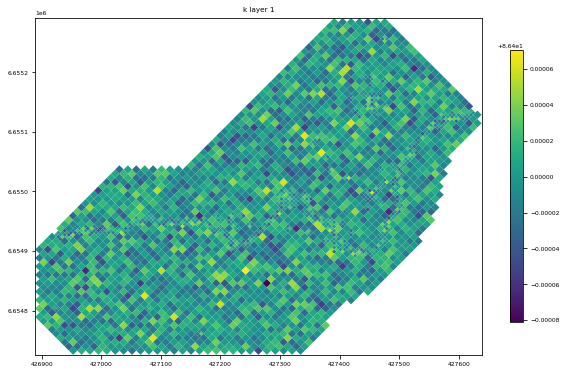

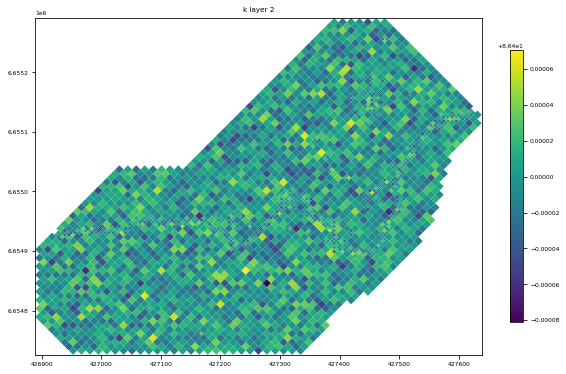

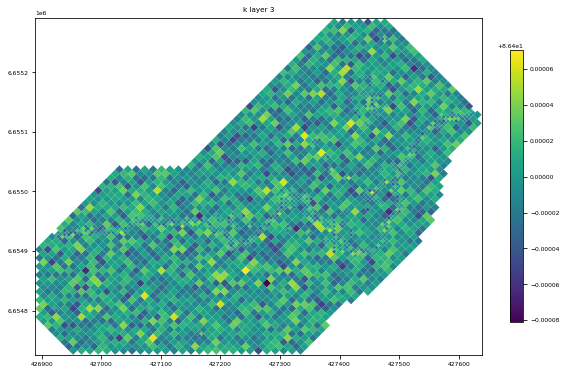

In [89]:
sim.get_model().npf.k.plot(colorbar=True, figsize=(10,10))

[<AxesSubplot:title={'center':'k33 layer 1'}>,
 <AxesSubplot:title={'center':'k33 layer 2'}>,
 <AxesSubplot:title={'center':'k33 layer 3'}>]

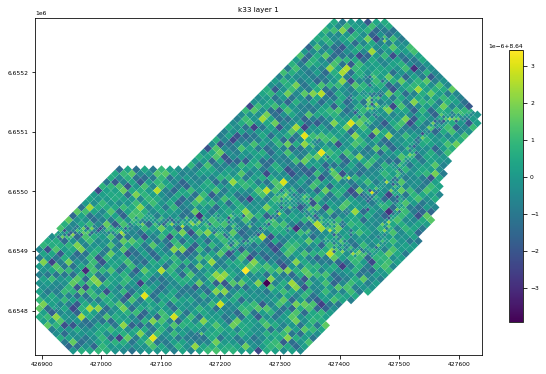

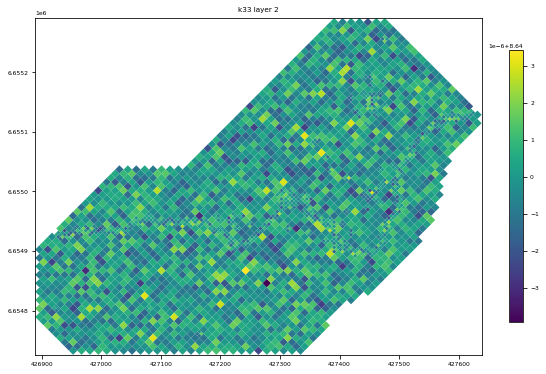

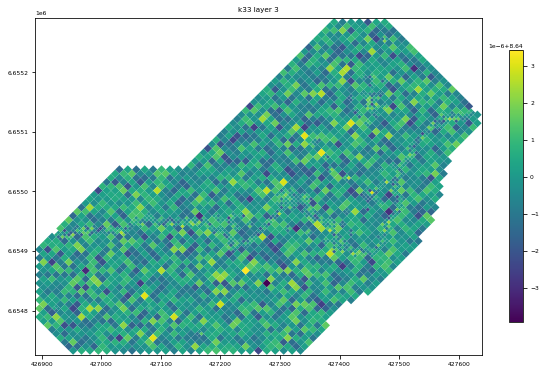

In [90]:
sim.get_model().npf.k33.plot(colorbar=True, figsize=(10,10))

[<AxesSubplot:title={'center':'sy layer 1'}>,
 <AxesSubplot:title={'center':'sy layer 2'}>,
 <AxesSubplot:title={'center':'sy layer 3'}>]

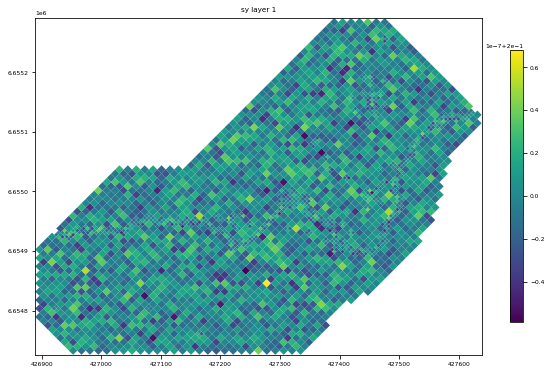

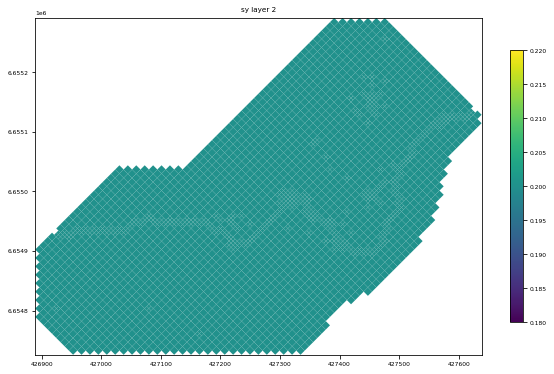

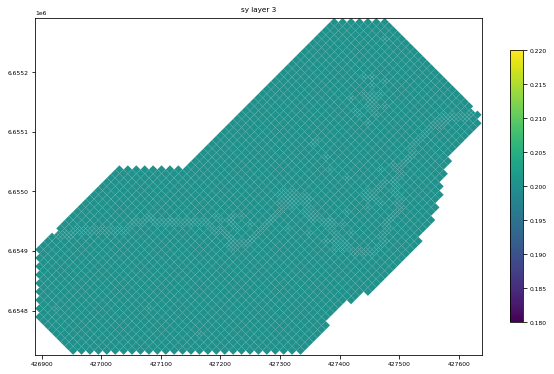

In [91]:
sim.get_model().sto.sy.plot(colorbar=True, figsize=(10,10))

[<AxesSubplot:title={'center':'ss layer 1'}>,
 <AxesSubplot:title={'center':'ss layer 2'}>,
 <AxesSubplot:title={'center':'ss layer 3'}>]

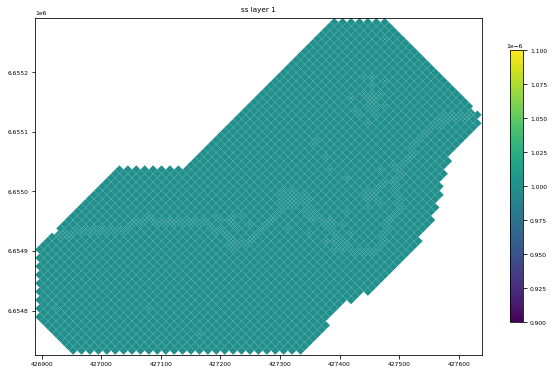

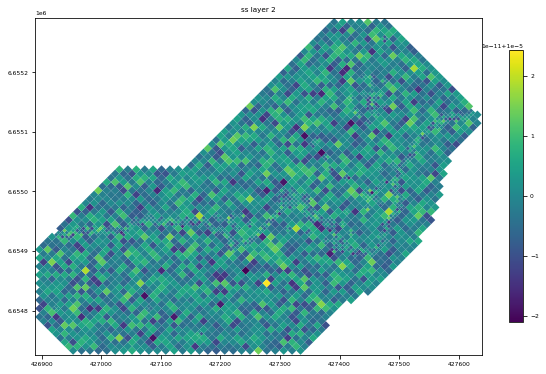

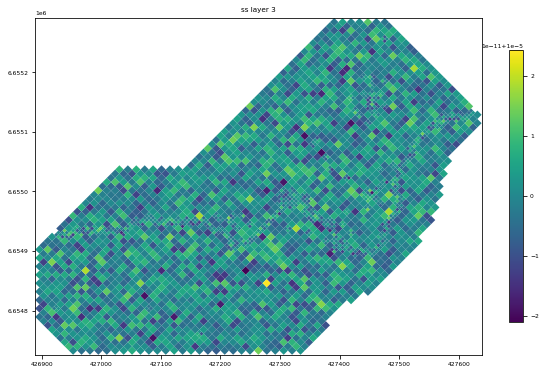

In [92]:
sim.get_model().sto.ss.plot(colorbar=True, figsize=(10,10))

In [ ]:
##### 

write_plproc_script(os.path.join(tmp_model_ws, 'plproc1.dat'), [
'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=experimental.disv.grb,    &
                            dimensions=3,                  &
                            slist_idomain = idomain,       &
                            slist_layernum = layer,        &
                            plist_bottom = bottom) # Is bottom needed?

### Read pilot-points file ###
cl_pp = read_list_file(file=pp3d_coarse.dat,               &
                       id_type=character,                  &
                       dimensions=3,                       &
                       slist=zone; col=5,                  &
                       slist=lyr; col=7,                   &
                       plist=kh_pp; col=8,                 &
                       plist=kv_pp; col=9,                 &
                       plist=sy_pp; col=10,                &
                       plist=ss_pp; col=11)


### Create CLIST partitions so that the function "write_model_input_file" writes ###
### a MODFLOW readable parameter file with the same length as                    ### 
### experimental.npf_k_layer1.txt                                                ###
### Is this the proper way to go about it?                                       ###
cl_mf_layer1 = cl_mf.partition_by_eqn(select=(layer==1))
cl_mf_layer2 = cl_mf.partition_by_eqn(select=(layer==2))
cl_mf_layer3 = cl_mf.partition_by_eqn(select=(layer==3))


### Calculate kriging factors for each CLIST partition ###
### If creating partitions is wrong, then this will be ###
### wrong as well...                                   ###
calc_kriging_factors_3d(target_clist=cl_mf_layer1,                   &
                        source_clist=cl_pp,                          &
                        file=ppfactors1.dat,                         &
                        variogram=exponential,                       &
                        a_hmax=32, a_hmin=28, a_vert=8,              &
                        ang1=60, ang2=20, ang3=0,                    &
                        kriging=ordinary,                            &
                        search_rad_max_hdir=130,                     &
                        search_rad_min_hdir=66,                      &
                        search_rad_vert=33,                          &
                        min_points=1,max_points=10)

calc_kriging_factors_3d(target_clist=cl_mf_layer2,                   &
                        source_clist=cl_pp,                          &
                        file=ppfactors2.dat,                         &
                        variogram=exponential,                       &
                        a_hmax=32, a_hmin=28, a_vert=8,              &
                        ang1=60, ang2=20, ang3=0,                    &
                        kriging=ordinary,                            &
                        search_rad_max_hdir=130,                     &
                        search_rad_min_hdir=66,                      &
                        search_rad_vert=33,                          &
                        min_points=1,max_points=10)

calc_kriging_factors_3d(target_clist=cl_mf_layer3,                   &
                        source_clist=cl_pp,                          &
                        file=ppfactors3.dat,                         &
                        variogram=exponential,                       &
                        a_hmax=32, a_hmin=28, a_vert=8,              &
                        ang1=60, ang2=20, ang3=0,                    &
                        kriging=ordinary,                            &
                        search_rad_max_hdir=130,                     &
                        search_rad_min_hdir=66,                      &
                        search_rad_vert=33,                          &
                        min_points=1,max_points=10)

### Write  ###
prop_mf_l1=new_plist(reference_clist=cl_mf_layer1, value=1.0)
prop_mf_l2=new_plist(reference_clist=cl_mf_layer2, value=1.0)
prop_mf_l3=new_plist(reference_clist=cl_mf_layer3, value=1.0)

### Write kh layer 1 ###
prop_mf_l1=86.4
prop_mf_l1=kh_pp.krige_using_file(file='ppfactors1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array_l1.tpl, model_input_file=experimental.npf_k_layer1.txt)

### Write kh layer 2 ###
prop_mf_l2=1.0E-2
prop_mf_l2=kh_pp.krige_using_file(file='ppfactors2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array_l2.tpl, model_input_file=experimental.npf_k_layer2.txt)

### Write kh layer 3 ###
prop_mf_l3=63.2
prop_mf_l3=kh_pp.krige_using_file(file='ppfactors3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array_l3.tpl, model_input_file=experimental.npf_k_layer3.txt)

### Write reports ###
report_all_entities(file=report1.dat)
cl_mf.report_dependent_lists(file='report2.dat')
'''
])